In [30]:
from ucimlrepo import fetch_ucirepo 

# fetch datasets
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
bike_sharing = fetch_ucirepo(id=275)

# Part 1

#### Code:

In [52]:
# Data Prep

features = breast_cancer_wisconsin_diagnostic.data.features.values
targets = breast_cancer_wisconsin_diagnostic.data.targets.values

classification_dict = {}

# M is 1 and B is 0
for i in range(len(features)):
	classification_dict[f"data[{i}]"] = {
		"features": features[i],
		"target": 1 if targets[i] == "M" else 0
	}

In [53]:
# KNN

def knn_classifier_with_euclidian_distance(train_data: {}, test_data: {}, k: int):
	if k < 1:
		raise ValueError("k must be greater than 0")
	
	if len(train_data) == 0:
		raise ValueError("train_data must not be empty")
	
	if len(test_data) == 0:
		raise ValueError("test_data must not be empty")

	if k > len(train_data):
		k = len(train_data)
  

	for test_element in test_data:
		for train_element in train_data:
			dist = 0
			
			for i in range(len(test_data[test_element]["features"])):
				dist += (test_data[test_element]["features"][i] - train_data[train_element]["features"][i]) ** 2
    
			train_data[train_element]["distance"] = dist ** 0.5
   
		k_nearest_neighboor = dict(sorted(train_data.items(), key= lambda item: item[1]["distance"])[:k])

		# count most freq label
		label_count = {}
		for key in k_nearest_neighboor:
			label = k_nearest_neighboor[key]["target"]
			if label in label_count:
				label_count[label] += 1
			else:
				label_count[label] = 1
    
		# get most freq label
		test_data[test_element]["target"] = max(label_count, key=lambda key: label_count[key])

	return test_data



In [54]:
# K Fold Cross Validation using Confusion Matrices

import random, time, numpy

def k_fold_cross_validation_knn_classification(data: {}, k_fold: int, k_nearest_neighboors: int, knn_func, random_seed=None):
	if k_fold < 1:
		raise ValueError("k_fold must be greater than 0")
	
	if len(data) == 0:
		raise ValueError("data must not be empty")

	if k_fold > len(data):
		k_fold = len(data)
  
	data_keys = list(data.keys())

	if random_seed is not None:
		random.seed(random_seed)
		random.shuffle(data_keys)

	# split data into k folds
	fold_count = len(data) // k_fold
	confusion_matrices = []
	accuracies = []
 

	start_time = time.time()

	for i in range(k_fold):
		test_keys = data_keys[i * fold_count: (i + 1) * fold_count] # 1 fold for testing
		train_keys = data_keys[:i * fold_count] + data_keys[(i + 1) * fold_count:] # remaining to train

		train_data = {key: data[key] for key in train_keys}
		test_data = {key: {"features": data[key]["features"]} for key in test_keys} # no label
  
		predicted_data = knn_func(train_data, test_data, k_nearest_neighboors)

		y_true = [data[key]["target"] for key in test_keys]
		y_predicted = [predicted_data[key]["target"] for key in test_keys]

		# accuracy = tp + tn / total
		accuracy = sum(yt == yp for yt, yp in zip(y_true, y_predicted)) / len(y_true) # y_true is equal to the size of the test set
		accuracies.append(accuracy)		
  
  		# confusion matrix
		tp = sum(yt == yp == 1 for yt, yp in zip(y_true, y_predicted))
		tn = sum(yt == yp == 0 for yt, yp in zip(y_true, y_predicted))
		fp = sum(yt == 0 and yp == 1 for yt, yp in zip(y_true, y_predicted))
		fn = sum(yt == 1 and yp == 0 for yt, yp in zip(y_true, y_predicted))

		# there are 2 classes here so the each confusion matrix will be 2x2
		confusion_matrices.append(
      		numpy.array([[tp, fp],
                     [fn, tn]])
		)

	end_time = time.time()
	elapsed_time = end_time - start_time

	avg_accuracy = sum(accuracies) / len(accuracies)

	return confusion_matrices, avg_accuracy, elapsed_time

#### Results:

In [57]:
confusion_matrices, avg_accuracy, elapsed_time = k_fold_cross_validation_knn_classification(classification_dict, 7, 7, knn_classifier_with_euclidian_distance, random_seed=81)

In [21]:
confusion_matrices, avg_accuracy, elapsed_time

([array([[37,  2],
         [ 1, 73]]),
  array([[39,  4],
         [ 7, 63]]),
  array([[26,  3],
         [ 6, 78]]),
  array([[42,  3],
         [ 2, 66]]),
  array([[42,  0],
         [ 8, 63]])],
 0.936283185840708,
 2.5325634479522705)

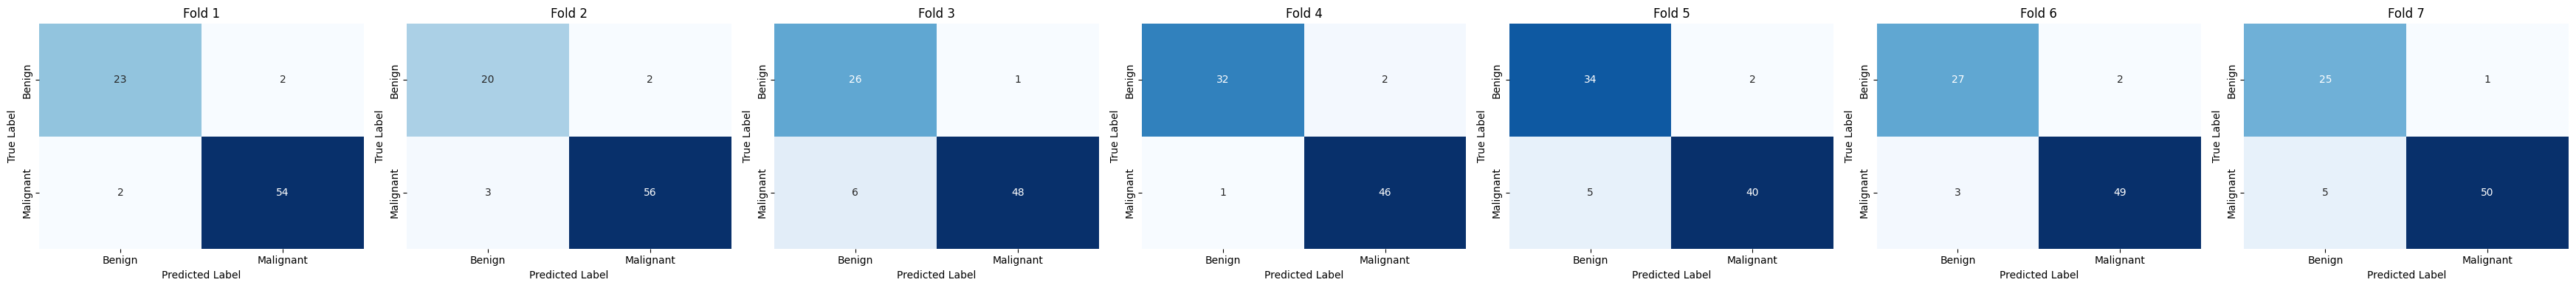

Average Accuracy (k-fold cross-validation): 0.9347
Total Runtime: 2.6582 seconds


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrices(conf_matrices):
    """
    Plots multiple confusion matrices from k-fold cross-validation.
    
    Args:
    conf_matrices (list): List of confusion matrices from k-fold validation.
    """
    num_folds = len(conf_matrices)
    fig, axes = plt.subplots(1, num_folds, figsize=(num_folds * 5, 4))

    if num_folds == 1:
        axes = [axes]  # Ensure axes is iterable when there's only 1 fold

    for i, cm in enumerate(conf_matrices):
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"], ax=ax)
        ax.set_title(f"Fold {i+1}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")

    plt.tight_layout()
    plt.show()

# Call the function to visualize confusion matrices
plot_confusion_matrices(confusion_matrices)

# Print the average accuracy and runtime
print(f"Average Accuracy (k-fold cross-validation): {avg_accuracy:.4f}")
print(f"Total Runtime: {elapsed_time:.4f} seconds")


#### Comments:

# Part 2

#### Code:

In [31]:
# Data Prep
import pandas as pd

features = bike_sharing.data.features.copy()

# convert dteday to datetime
features["dteday"] = pd.to_datetime(features["dteday"])
features["dteday_new"] = (features["dteday"] - features["dteday"].min()).dt.days
features["dteday"] = features["dteday_new"]
features.drop(columns=["dteday_new"], inplace=True)
# features = features.values


In [34]:
features = features.values
targets = bike_sharing.data.targets.values

regression_dict = {}

for i in range(len(features)):
	regression_dict[f"data[{i}]"] = {
		"features": features[i],
		"target": targets[i]
	}
 

In [42]:
# KNN regressor with manhattan distance

def knn_regressor_with_manhattan_distance(train_data: {}, test_data: {}, k: int):
	if k < 1:
		raise ValueError("k must be greater than 0")
	
	if len(train_data) == 0:
		raise ValueError("train_data must not be empty")
	
	if len(test_data) == 0:
		raise ValueError("test_data must not be empty")

	if k > len(train_data):
		k = len(train_data)
  
	# index = 0
	for test_element in test_data:
		# print("test element: ", index)
		# index += 1
		for train_element in train_data:
			dist = 0
			
			for i in range(len(test_data[test_element]["features"])):
				dist += abs(test_data[test_element]["features"][i] - train_data[train_element]["features"][i])
			train_data[train_element]["distance"] = dist

    
		k_nearest_neighboor = dict(sorted(train_data.items(), key= lambda item: item[1]["distance"])[:k])

		# neighbor is a key
		test_data[test_element]["target"] = sum(train_data[neighbor]["target"] for neighbor in k_nearest_neighboor) / k

	return test_data



In [36]:
# K Fold Cross Validation using Mean Square Error

import time, random

def k_fold_cross_validation_knn_regression(data: {}, k_fold: int, k_nearest_neighboors: int, knn_func, random_seed=None):
	if k_fold < 1:
		raise ValueError("k_fold must be greater than 0")
	
	if len(data) == 0:
		raise ValueError("data must not be empty")

	if k_fold > len(data):
		k_fold = len(data)
  
	data_keys = list(data.keys())

	if random_seed is not None:
		random.seed(random_seed)
		random.shuffle(data_keys)

	# split data into k folds
	fold_count = len(data) // k_fold

	start_time = time.time()
	MSEs = []

	for i in range(k_fold):
		test_keys = data_keys[i * fold_count: (i + 1) * fold_count] # 1 fold for testing
		train_keys = data_keys[:i * fold_count] + data_keys[(i + 1) * fold_count:] # remaining to train

		train_data = {key: data[key] for key in train_keys}
		test_data = {key: {"features": data[key]["features"]} for key in test_keys} # no label
  
		predicted_data = knn_func(train_data, test_data, k_nearest_neighboors)

		y_true = [data[key]["target"] for key in test_keys]
		y_predicted = [predicted_data[key]["target"] for key in test_keys]

		MSE = sum((yt - yp)**2 for yt, yp in zip(y_true, y_predicted)) / len(y_true)
		MSEs.append(MSE)

	end_time = time.time()
	elapsed_time = end_time - start_time

	avg_MSE = numpy.mean(MSEs)

	return avg_MSE, elapsed_time


#### Results:

In [49]:
import random
import numpy

# Ensure reproducibility
random_seed = 42
random.seed(random_seed)

# Select 500 random keys from regression_dict
random_keys = random.sample(list(regression_dict.keys()), 5000)

# Create rand_reg_dict with only 500 random samples
rand_reg_dict = {key: regression_dict[key] for key in random_keys}

# Perform K-Fold Cross Validation on rand_reg_dict
avg_MSE, elapsed_time = k_fold_cross_validation_knn_regression(
    rand_reg_dict, 5, 5, knn_func=knn_regressor_with_manhattan_distance, random_seed=random_seed
)

# Print Results
print(f"Average MSE (5-fold cross-validation on 500 random samples): {avg_MSE:.4f}")
print(f"Total Runtime: {elapsed_time:.4f} seconds")


Average MSE (5-fold cross-validation on 500 random samples): 15335.1373
Total Runtime: 112.5120 seconds


In [37]:
avg_MSE, elapsed_time = k_fold_cross_validation_knn_regression(regression_dict, 5, 5, knn_regressor_with_manhattan_distance, random_seed=42)

test element:  0
test element:  1
test element:  2
test element:  3
test element:  4
test element:  5
test element:  6
test element:  7
test element:  8
test element:  9
test element:  10
test element:  11
test element:  12
test element:  13
test element:  14
test element:  15
test element:  16
test element:  17
test element:  18
test element:  19
test element:  20
test element:  21
test element:  22
test element:  23
test element:  24
test element:  25
test element:  26
test element:  27
test element:  28
test element:  29
test element:  30
test element:  31
test element:  32
test element:  33
test element:  34
test element:  35
test element:  36
test element:  37
test element:  38
test element:  39
test element:  40
test element:  41
test element:  42
test element:  43
test element:  44
test element:  45
test element:  46
test element:  47
test element:  48
test element:  49
test element:  50
test element:  51
test element:  52
test element:  53
test element:  54
test element:  55
te

KeyboardInterrupt: 

# Part 3